# Calculate Automation Probabilities of Jobs on the Swiss Labour Market

## Content
1. [Import Data](#import)
2. [Normalize the Data](#normalize)
3. [Calculate Weighted Sum from Coefficients](#weighted-sum)
4. [Calculate Probability of Automation](#probability)
5. [Display Results](#display)
6. [Save Results](#save)

In [16]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math as m

<a id='import'></a>
## Import Data

In [17]:
# Replace 'filename.csv' with the path to your CSV file
df_swiss_jobs = pd.read_csv('files/switzerland_occupations.csv')
coefficients_outside_95 = pd.read_csv('files/coefficients_outside_95.csv')
intercept = pd.read_csv('files/intercept.csv').iloc[0, 0]
not_automatable = [item[0] for item in pd.read_csv("files/not_automatable.csv").values.tolist()]

In [18]:
df_swiss_jobs.head(2)

,isco08,Name_de,Berufshauptgruppe,s1,s2,s3,s4,s5,s6,s7,...,a43,a44,a45,a46,a47,a48,a49,a50,a51,a52
0,2655,Schauspieler,2,0.72,0.72,0.69,0.69,0.50,0.50,0.50,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2612,Richter,2,0.81,0.75,0.81,0.72,0.81,0.66,0.56,...,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
coefficients_outside_95.head(2)

,id,coefficient,skill,skill_description
0,s21,-1.5729,Operations Analysis,Analyzing needs and product requirements to cr...
1,a12,-1.4429,Deductive Reasoning,The ability to apply general rules to specific...


In [20]:
cols_to_keep = not_automatable
cols_to_keep.extend(['isco08', 'Name_de', 'Berufshauptgruppe'])

# Drop the other columns
df_swiss_jobs = df_swiss_jobs[cols_to_keep]

# Display the first few rows of the DataFrame
df_swiss_jobs.head(5)

,a6,s35,s19,a8,s21,s27,s17,s32,a38,s16,s5,s34,s24,s8,isco08,Name_de,Berufshauptgruppe
0,0.69,0.00,0.25,0.53,0.19,0.00,0.35,0.00,0.13,0.38,0.50,0.0,0.06,0.47,2655,Schauspieler,2
1,0.47,0.00,0.44,0.75,0.22,0.00,0.41,0.13,0.00,0.50,0.81,0.0,0.19,0.72,2612,Richter,2
2,0.47,0.56,0.50,0.72,0.44,0.28,0.35,0.28,0.10,0.41,0.72,0.5,0.28,0.63,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3
3,0.47,0.00,0.72,0.72,0.50,0.00,0.47,0.28,0.00,0.47,0.81,0.0,0.22,0.75,2120,"Mathematiker, Aktuare und Statistiker",2
4,0.69,0.00,0.53,0.66,0.44,0.00,0.53,0.19,0.00,0.60,0.75,0.0,0.19,0.63,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1


<a id='normalize'></a>
## Normalize the Data

In [21]:
# Initialize a scaler
scaler = StandardScaler()

# Define the columns to scale
cols_to_scale = [col for col in df_swiss_jobs.columns if col not in ['isco08', 'Name_de',"Berufshauptgruppe"]]

# Scale only these columns
df_swiss_jobs_scaled = df_swiss_jobs.copy()
df_swiss_jobs_scaled[cols_to_scale] = scaler.fit_transform(df_swiss_jobs[cols_to_scale])

df_swiss_jobs_scaled.head(5)

,a6,s35,s19,a8,s21,s27,s17,s32,a38,s16,s5,s34,s24,s8,isco08,Name_de,Berufshauptgruppe
0,1.867520,-1.412844,-1.247458,-1.171875,-0.431373,-0.484664,-0.455018,-1.405676,0.090285,-0.465700,-1.092364,-0.858883,-1.339385,-0.634561,2655,Schauspieler,2
1,0.214332,-1.412844,0.089496,1.008783,-0.228440,-0.484664,-0.031536,-0.127176,-0.989010,0.428698,1.625179,-0.858883,0.150205,1.380598,2612,Richter,2
2,0.214332,1.485398,0.511693,0.711420,1.259738,1.623438,-0.455018,1.348016,-0.158783,-0.242101,0.836215,1.464947,1.181460,0.655141,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3
3,0.214332,-1.412844,2.059745,0.711420,1.665605,-0.484664,0.391947,1.348016,-0.989010,0.205098,1.625179,-0.858883,0.493957,1.622417,2120,"Mathematiker, Aktuare und Statistiker",2
4,1.867520,-1.412844,0.722791,0.116695,1.259738,-0.484664,0.815429,0.462901,-0.989010,1.174030,1.099203,-0.858883,0.150205,0.655141,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1


<a id='weighted-sum'></a>
## Calculate Weighted Sum from Coefficients

In [22]:
# Create a dictionary from the coefficients DataFrame
coef_dict = coefficients_outside_95.set_index('id')['coefficient'].to_dict()

In [23]:
# Filter coef_dict to only include keys present in df_swiss_jobs_scaled's columns
# Exclude 'fo_probability' and 'fo_computerisation'
filtered_coef_dict = {k: coef_dict[k] for k in df_swiss_jobs_scaled.columns if k in coef_dict and k not in ['Name_de', 'isco08',"Berufshauptgruppe"]}

# Create a list of weights in the same order as the DataFrame columns
weights = [filtered_coef_dict[col] for col in df_swiss_jobs_scaled.columns if col in filtered_coef_dict]

# Convert the DataFrame to a numpy array
df_array = df_swiss_jobs_scaled[filtered_coef_dict.keys()].values

# Calculate the weighted sum using np.dot
weighted_sum = np.dot(df_array, weights)

# Save the weighted sum in the DataFrame
df_swiss_jobs_scaled['weighted_sum'] = weighted_sum

df_swiss_jobs_scaled.head(5)

,a6,s35,s19,a8,s21,s27,s17,s32,a38,s16,s5,s34,s24,s8,isco08,Name_de,Berufshauptgruppe,weighted_sum
0,1.867520,-1.412844,-1.247458,-1.171875,-0.431373,-0.484664,-0.455018,-1.405676,0.090285,-0.465700,-1.092364,-0.858883,-1.339385,-0.634561,2655,Schauspieler,2,-0.762073
1,0.214332,-1.412844,0.089496,1.008783,-0.228440,-0.484664,-0.031536,-0.127176,-0.989010,0.428698,1.625179,-0.858883,0.150205,1.380598,2612,Richter,2,-2.413115
2,0.214332,1.485398,0.511693,0.711420,1.259738,1.623438,-0.455018,1.348016,-0.158783,-0.242101,0.836215,1.464947,1.181460,0.655141,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3,-2.210210
3,0.214332,-1.412844,2.059745,0.711420,1.665605,-0.484664,0.391947,1.348016,-0.989010,0.205098,1.625179,-0.858883,0.493957,1.622417,2120,"Mathematiker, Aktuare und Statistiker",2,-4.687611
4,1.867520,-1.412844,0.722791,0.116695,1.259738,-0.484664,0.815429,0.462901,-0.989010,1.174030,1.099203,-0.858883,0.150205,0.655141,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1,-5.929980


<a id='probability'></a>
## Calculate Probability of Automation

In [24]:
# Calculate the probabilities
prob_list = [m.exp(x_i + intercept) / (1 + m.exp(x_i + intercept)) for x_i in weighted_sum]

In [25]:
# Add the probabilities to the DataFrame
df_swiss_jobs_scaled['probability'] = prob_list

df_swiss_jobs_scaled.head(5)

,a6,s35,s19,a8,s21,s27,s17,s32,a38,s16,s5,s34,s24,s8,isco08,Name_de,Berufshauptgruppe,weighted_sum,probability
0,1.867520,-1.412844,-1.247458,-1.171875,-0.431373,-0.484664,-0.455018,-1.405676,0.090285,-0.465700,-1.092364,-0.858883,-1.339385,-0.634561,2655,Schauspieler,2,-0.762073,0.999202
1,0.214332,-1.412844,0.089496,1.008783,-0.228440,-0.484664,-0.031536,-0.127176,-0.989010,0.428698,1.625179,-0.858883,0.150205,1.380598,2612,Richter,2,-2.413115,0.995853
2,0.214332,1.485398,0.511693,0.711420,1.259738,1.623438,-0.455018,1.348016,-0.158783,-0.242101,0.836215,1.464947,1.181460,0.655141,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3,-2.210210,0.996612
3,0.214332,-1.412844,2.059745,0.711420,1.665605,-0.484664,0.391947,1.348016,-0.989010,0.205098,1.625179,-0.858883,0.493957,1.622417,2120,"Mathematiker, Aktuare und Statistiker",2,-4.687611,0.961088
4,1.867520,-1.412844,0.722791,0.116695,1.259738,-0.484664,0.815429,0.462901,-0.989010,1.174030,1.099203,-0.858883,0.150205,0.655141,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1,-5.929980,0.877009


<a id='display'></a>
## Display Results

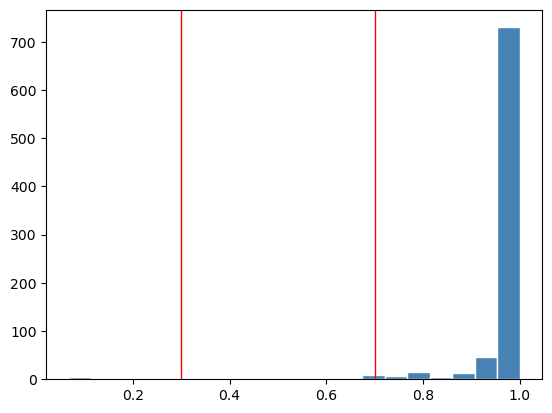

In [26]:
# Get the values
x = df_swiss_jobs_scaled["probability"].values

# Calculate the histogram
hist, bins = np.histogram(x, bins=20)

# Calculate the width and center of the bars
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# Plot the histogram
plt.bar(center, hist, align='center', width=width, color='#4682B4', edgecolor='white')

# Add lines at 0.3 and 0.7
plt.axvline(0.3, color='r', linewidth=1)
plt.axvline(0.7, color='r', linewidth=1)

# Show the plot
plt.show()

In [27]:
# Jobs with probability below 0.3
jobs_below_03 = df_swiss_jobs_scaled[df_swiss_jobs_scaled['probability'] <= 0.3]
print(f"Number of jobs with probability below 0.3: {len(jobs_below_03)}")

# Jobs with probability between 0.3 and 0.7
jobs_between_03_and_07 = df_swiss_jobs_scaled[(df_swiss_jobs_scaled['probability'] > 0.3) & (df_swiss_jobs_scaled['probability'] <= 0.7)]
print(f"Number of jobs with probability between 0.3 and 0.7: {len(jobs_between_03_and_07)}")

# Jobs with probability above 0.7
jobs_above_07 = df_swiss_jobs_scaled[df_swiss_jobs_scaled['probability'] > 0.7]
print(f"Number of jobs with probability above 0.7: {len(jobs_above_07)}")

Number of jobs with probability below 0.3: 10
Number of jobs with probability between 0.3 and 0.7: 17
Number of jobs with probability above 0.7: 819


In [28]:
df_swiss_jobs_scaled.head(2)

,a6,s35,s19,a8,s21,s27,s17,s32,a38,s16,s5,s34,s24,s8,isco08,Name_de,Berufshauptgruppe,weighted_sum,probability
0,1.867520,-1.412844,-1.247458,-1.171875,-0.431373,-0.484664,-0.455018,-1.405676,0.090285,-0.465700,-1.092364,-0.858883,-1.339385,-0.634561,2655,Schauspieler,2,-0.762073,0.999202
1,0.214332,-1.412844,0.089496,1.008783,-0.228440,-0.484664,-0.031536,-0.127176,-0.989010,0.428698,1.625179,-0.858883,0.150205,1.380598,2612,Richter,2,-2.413115,0.995853


<a id='save'></a>
## Save Results

In [29]:
df_probabilities = df_swiss_jobs_scaled[['Name_de', 'Berufshauptgruppe', 'probability', "isco08"]].copy()
df_pytorch_model = df_swiss_jobs_scaled.drop(columns=["weighted_sum"])

In [30]:
df_probabilities['probability'] = df_probabilities['probability'].round(4)
df_probabilities.to_csv('files/switzerland_probabilities.csv', index=False)